# Estimating the Proc2D mean in the Cov.-Smoothing Basis

Import libraries.

In [20]:
# Required
library(mgcv)
library(sparseFLMM)
library(dplyr)

# To deal with SRV framework
#detach("package:elasdics2d", unload=TRUE)
devtools::install("../../elasdics")
#library(elasdics2d)
library(elasdics)

# Plotting
library(ggplot2)
library(gridExtra)
library(viridis)
library(rgl)
library(fields)

# Datasets
source("../scripts/load_datasets.R")

# Seed 
set.seed(18)


v  checking for file 'D:\Dropbox\Statistik\elasdics/DESCRIPTION' (385ms)
-  preparing 'elasdics2d': (867ms)
v  checking DESCRIPTION meta-information
-  checking for LF line-endings in source and make files and shell scripts
-  checking for empty or unneeded directories
-  building 'elasdics2d_0.1.0.tar.gz'
   
Running "C:/Users/Manuel/ANACON~1/envs/rstudio/lib/R/bin/x64/Rcmd.exe" \
  INSTALL \
  "C:\Users\Manuel\AppData\Local\Temp\RtmpsX7JEf/elasdics2d_0.1.0.tar.gz" \
  --install-tests 
* installing to library 'C:/Users/Manuel/Anaconda3/envs/rstudio/lib/R/library'
* installing *source* package 'elasdics2d' ...
** using staged installation
** R
** tests
** byte-compile and prepare package for lazy loading
No man pages found in package ** help
 'elasdics2d' 
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a 

## Prepare Dataset
Load dataset and transform curves to SRV framework.

In [3]:
# Simulate 2D spirals.
data_curves <- curves.spiral(n_curves=10, rotate=TRUE, scale=TRUE, center=TRUE)

# Create arc length parametrization.
data_curves <- lapply(data_curves, function(data_curve) {
    data.frame(t = get_arc_length_param(data_curve), data_curve)
})

# Get SRV data curves.
srv_data_curves <- lapply(data_curves, get_srv_from_points)

# Reparametrize SRV data curves and put curves into long (stacked) format.
t_optims <- lapply(srv_data_curves, function(srv_data_curve) { c(srv_data_curve$t, 1) })
model_data <- elasdics:::get_model_data(t_optims, srv_data_curves, knots=c(), type="smooth")

Transform curves from real plane to complex. Add a curve id column (for the covariance estimation).

In [4]:
# Create curve id column for model_data. (hacky!)
ids <- do.call(c, lapply(t_optims, function(x) length(x)-1))
ids <- rbind(1:length(ids), ids)
ids <- apply(ids, 2, function(x) rep(x[1], times = x[2]))
ids <- do.call(c, as.list(ids))         
             
# x,y to complex. Add id column.
model_data_complex <- complex(re=model_data[,2], im=model_data[,3]) %>% matrix(nrow=dim(model_data)[1])
model_data_complex <- data.frame(id = ids, m_long = model_data$m_long, q_m_long = model_data_complex)

## Estimate Covariance Surface
Build covariance response on (s,t) grid.

In [5]:
cov_dat <- lapply(split(model_data_complex, model_data_complex$id), function(x) {
    combs <- combn(1:nrow(x),2)
    data.frame(
        t = x$m_long[combs[1,]],
        s = x$m_long[combs[2,]],
        qq = x$q_m_long[combs[1,]] * Conj(x$q_m_long[combs[2,]])
    )
})
cov_dat <- do.call(rbind,cov_dat)

Fit covariance surface using ```mgcv```.

In [27]:
# Parameters for covariance smoothing
knots = seq(0,1,length=11) 
cov.m = 0 # basis order (spline degree-1)
cov.d = 2 # penalty
# Using knots
knotl = 1 / ( length(knots) - 1 )  # mean length of a knot
cov.knots = c(rep(-knotl,cov.m+1), knots, rep(1+knotl,cov.m+1))  # asusmes cov.m is 0 or 1.
#cov.knots = c(rep(0,cov.m+1), knots, rep(1,cov.m+1))  # knots at 0,1
cov.k = length(cov.knots) - cov.m - 2 # basis dimension.


# Smooth covariance surface
cov_fit_re <- bam(Re(qq) ~ s(t, s, bs="symm", k = cov.k, m = c(cov.m, cov.d),
                            fx = FALSE, xt = list(skew = FALSE)),
                  data = cov_dat, method = "REML", knots=list(t = cov.knots, s = cov.knots))
cov_fit_im <- bam(Im(qq) ~ -1 + s(t, s, bs="symm", k = cov.k, m = c(cov.m, cov.d),
                                  fx = FALSE, xt = list(skew = TRUE)),
                  data = cov_dat, method = "REML", knots=list(t = cov.knots, s = cov.knots))

Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"


Plot covariance surface on a grid.

In [28]:
# Define covariance surface grid (s,t).
arg.grid = seq(0, 1, len=101)
cov.grid = expand.grid(t = arg.grid, s = arg.grid)
# Evaluate fit on grid.
cov.re = predict(cov_fit_re, newdata = cov.grid)
cov.im = predict(cov_fit_im, newdata = cov.grid)

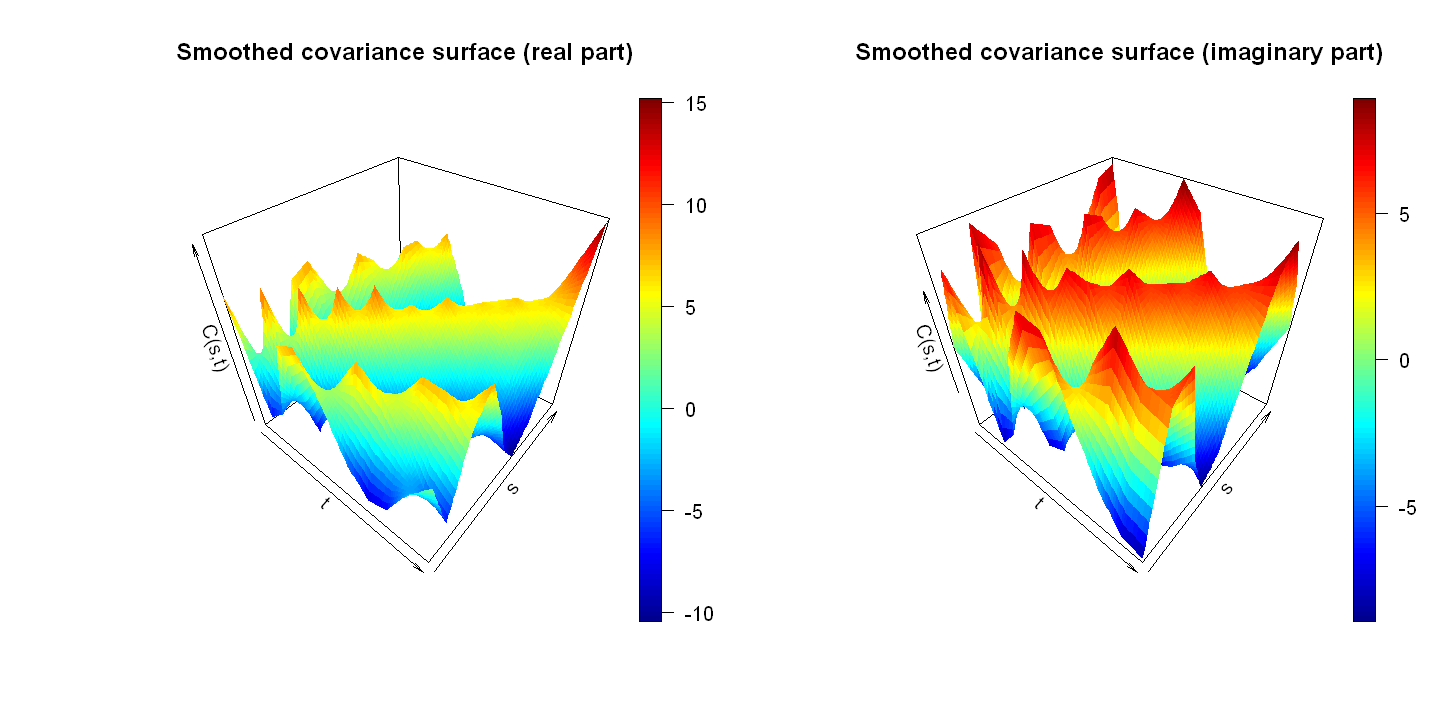

In [29]:
options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2), mar=c(4,4,4,1), oma=c(0.5,0.5,0.5,0))
# From 'fdapace/src/R/CreateCovPlot.R'
args1 <- list(
    xlab='t', ylab='s', zlab = 'C(s,t)',
    main = 'Smoothed covariance surface (real part)'
)
args2 = list (x = arg.grid, y = arg.grid, z = matrix(cov.re,nrow=101))
do.call(plot3D::persp3D, c(args2, args1))

# From 'fdapace/src/R/CreateCovPlot.R'
args1 <- list(
    xlab='t', ylab='s', zlab = 'C(s,t)',
    
    main = 'Smoothed covariance surface (imaginary part)'
)
args2 = list (x = arg.grid, y = arg.grid, z = matrix(cov.im,nrow=101))
do.call(plot3D::persp3D, c(args2, args1))

## Estimate Procrustes Mean Shape in fixed Basis

Extract basis functions from covariance smoothing.

Note: Using ```bs="ps"``` here.

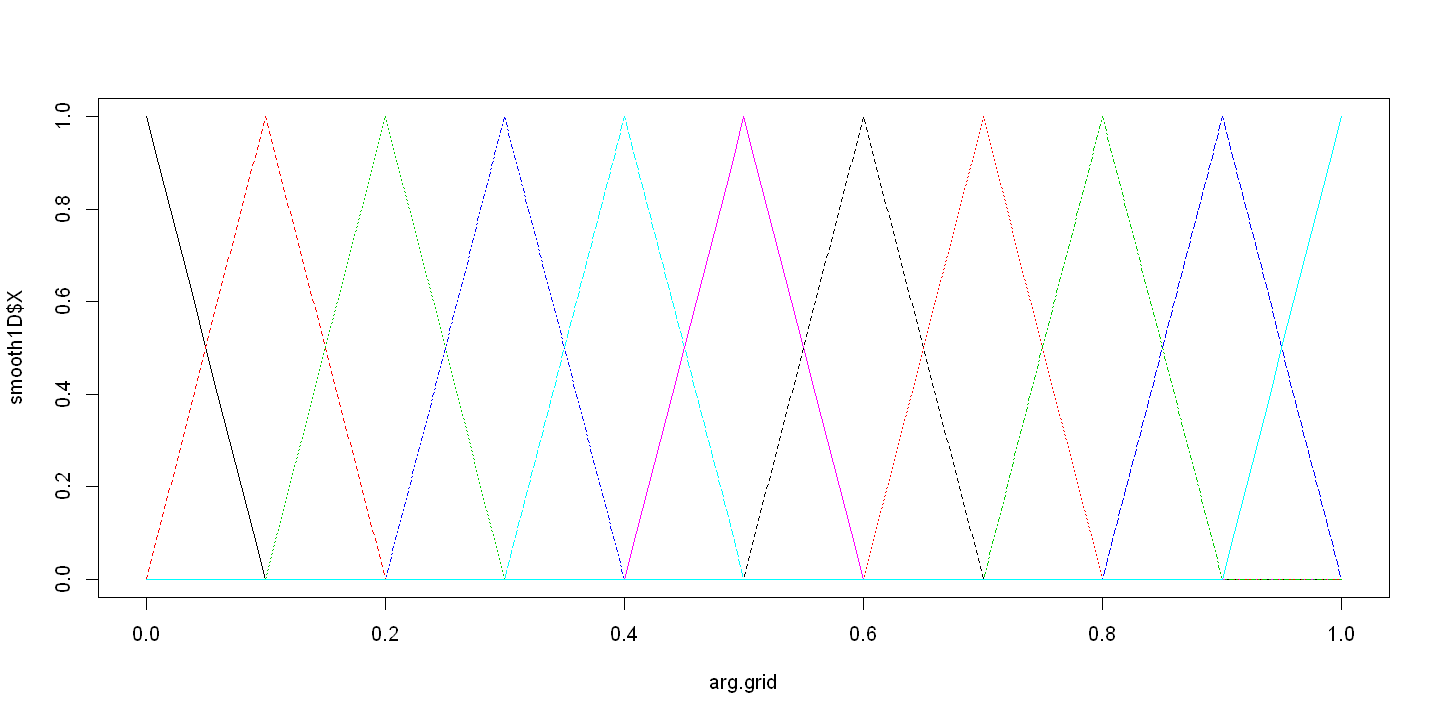

In [30]:
smooth1D <- smooth.construct(s(t, bs="ps", k = cov.k, m = c(cov.m, cov.d),
                              fx = FALSE),
                            data = list(t=arg.grid), knots=list(t=cov.knots))
matplot(arg.grid, smooth1D$X, t = "l")

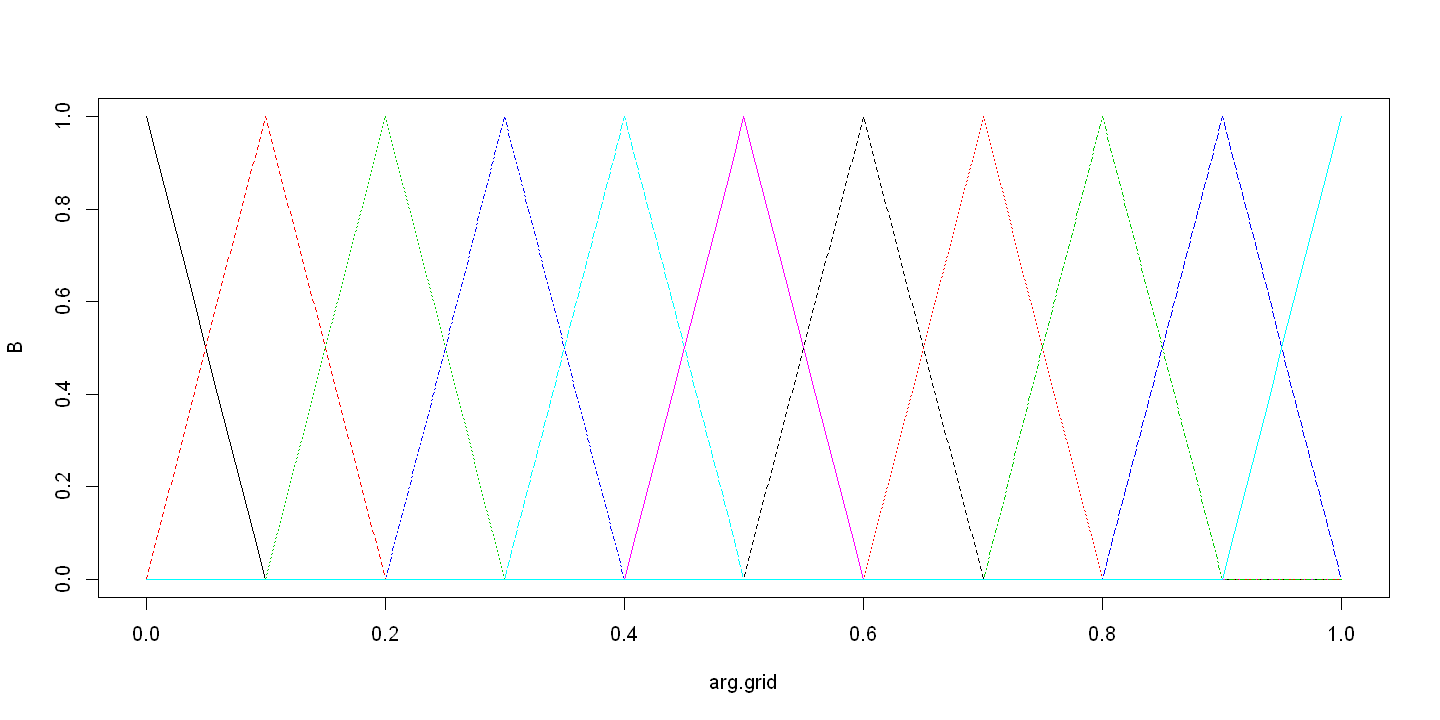

In [31]:
B = elasdics:::make_design(arg.grid, knots)
matplot(arg.grid, B, t = "l")

#### Function for extracting tensor product coefficient matrix.

In [32]:
get_coef_matrix <- function(model){
    F <- model$smooth[[1]]$bs.dim
    beta <- model$smooth[[1]]$Z %*% model$coefficients
    matrix(beta, nrow=F, ncol=F)
}

In [33]:
build_gram_matrix <- function(smooth){
    order = smooth$m[1] + 2  # degree + 1
    knots = smooth$knots  # inner+outer knots
    if( order == 1 ){
        diag(smooth$bs.dim)
    } else {
        osb_smooth = orthogonalsplinebasis::SplineBasis(knots,order=order)
        orthogonalsplinebasis::GramMatrix(osb_smooth)
    }
}

G <- build_gram_matrix(smooth1D)

In [34]:
beta.mat.re <- get_coef_matrix(cov_fit_re)
beta.mat.im <- get_coef_matrix(cov_fit_im)

beta.mat <- matrix( 
    complex(real = as.vector(beta.mat.re), imaginary = as.vector(beta.mat.im)),
    ncol = cov.k)
beta.mat.inv = solve(beta.mat)

In [35]:
# Calculate largest eigenvector
pca <- eigen(t(chol(solve(G))) %*% beta.mat %*% chol(solve(G)))
coefs.mean <- pca$vectors[,1]

In [36]:
qt <- smooth1D$X %*% coefs.mean
qt.xy <- data.frame(t=arg.grid, X1=Re(qt), X2=Im(qt))
bt.xy <- get_points_from_srv(qt.xy)

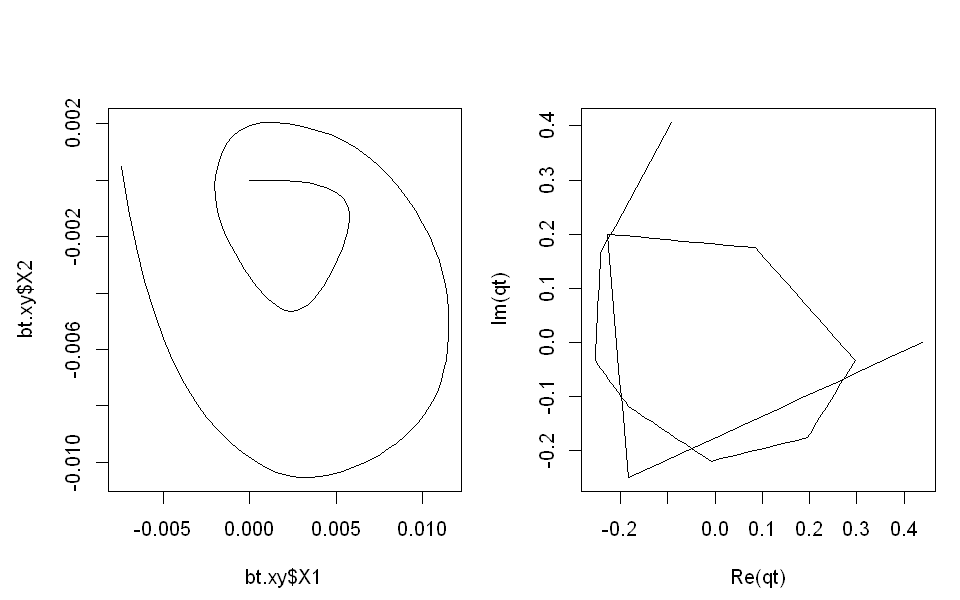

In [37]:
options(repr.plot.width=8, repr.plot.height=5)
par(mfrow=c(1,2), mar=c(4,4,4,1), oma=c(0.5,0.5,0.5,0))
matplot(bt.xy$X1, bt.xy$X2, t="l")
matplot(Re(qt), Im(qt), t="l")

### Plot Procrustes Fits + Mean from fixed basis (Note: No warping!)
Note: this is super hacky and just for illustration purposes. ^_^

In [38]:
bt.xy <- center_curve(bt.xy)

align_curves_proc2d <- function(mean, data_curve){
    t <- data_curve[,1]
    b <- as.matrix(data_curve[,-1])
    b_x <- approx(x=t, y=b[,1], xout=arg.grid)$y
    b_y <- approx(x=t, y=b[,2], xout=arg.grid)$y
    
    #b_eval <- make_design(arg.grid, knots = data_curve$t) %*% b  # This is bullshit.
    #b_compl <- complex(real = b_eval[,1], imaginary = b_eval[,2])
    
    b_compl <- complex(real=b_x, imaginary=b_y)
    m_compl <- complex(real = mean[,1], imaginary = mean[,2])
    
    bm <- Conj(b_compl) %*% Conj(m_compl)
    bb <- Re(Conj(b_compl) %*% b_compl)
    pfit <- c(bm/bb) * b_compl

    data.frame(t = arg.grid, X1 = Re(pfit), X2 = Im(pfit))
}


pfits <- lapply(data_curves, function(x) {
    pfit <- align_curves_proc2d(bt.xy[-length(bt.xy),],x)
})

interpolated pfits

In [39]:
pfits <- lapply(1:length(srv_data_curves), function(j) {
    # Grab warped srv_data_curve from model_data.
    q <- model_data_complex[model_data_complex$id == j,]
    # !!!! Calculate overlap of arg.grid and t_optims
    idx <- findInterval(arg.grid, q$m_long)
    idx.bool <- which(idx > 0 & idx < length(q$m_long))
    arg.grid.x <- arg.grid[idx.bool]
    # Linear interpolation.
    q_approx_x <- approx(x=q$m_long, y=Re(q$q_m_long), xout=arg.grid.x)$y
    q_approx_y <- approx(x=q$m_long, y=Im(q$q_m_long), xout=arg.grid.x)$y
    q_approx <- complex(real=q_approx_x, imaginary=q_approx_y)
    # Evaluate mean function on grid.
    mean_eval <- elasdics2d:::make_design(arg.grid.x, knots=knots, closed = FALSE, type = "smooth") %*% coefs.mean
    # Calculate qm and qq over arg.grid.x
    qm <- t(Conj(q_approx)) %*% Conj(mean_eval)
    qq <- t(Conj(q_approx)) %*% q_approx
    # Calculate G and b (Note: using "<<-" is not good practice...)
    #G_optims[j] <<- Arg(qm)
    # Note: squared to adjust for SRV framework. b is on data_curve level!!!
    #b_optims[j] <<- (Mod(qm) / Re(qq))^2
    # Calculate procrustes fit of original srv_data_curve
    # Note: warping is performed on the original srv_data_curves not on model_data!
    srv_complex = complex(real = srv_data_curves[[j]][,2], imaginary = srv_data_curves[[j]][,3])
    pfit <- as.vector(qm) * srv_complex / as.vector(qq)
    pfit <- data.frame(t = srv_data_curves[[j]][,1], X1 = Re(pfit), X2 = Im(pfit))
    center_curve(get_points_from_srv(pfit))
})

smoothed pfits

In [40]:
pfits_coef <- lapply(1:length(srv_data_curves), function(j) {

    q <- model_data_complex[model_data_complex$id == j,]
    q_B <- elasdics2d:::make_design(q$m_long, knots)
    q_coefs <- solve( t(Conj(q_B)) %*% q_B + t(beta.mat.inv) ) %*% t(Conj(q_B)) %*% q$q_m_long
    
    qm <- t(Conj(q_coefs)) %*% G %*% Conj(coefs.mean)
    qq <- t(Conj(q_coefs)) %*% G %*% q_coefs # always real.
    
    # Calculate fit on unwarped srv curves...
    srv_complex <- complex(real = srv_data_curves[[j]][,2], imaginary = srv_data_curves[[j]][,3])
    
    qt <- c(qm/qq) * srv_complex
    qt <- data.frame(t = srv_data_curves[[j]][,1], X1 = Re(qt), X2 = Im(qt))
    bt <- get_points_from_srv(qt)
    
    #p <- c(qm/qq) * q[,3]
    #pt <- data.frame(t = q$m_long, X1 = Re(p), X2 = Im(p))
    #bt <- get_points_from_srv(pt)
    center_curve(bt)
})

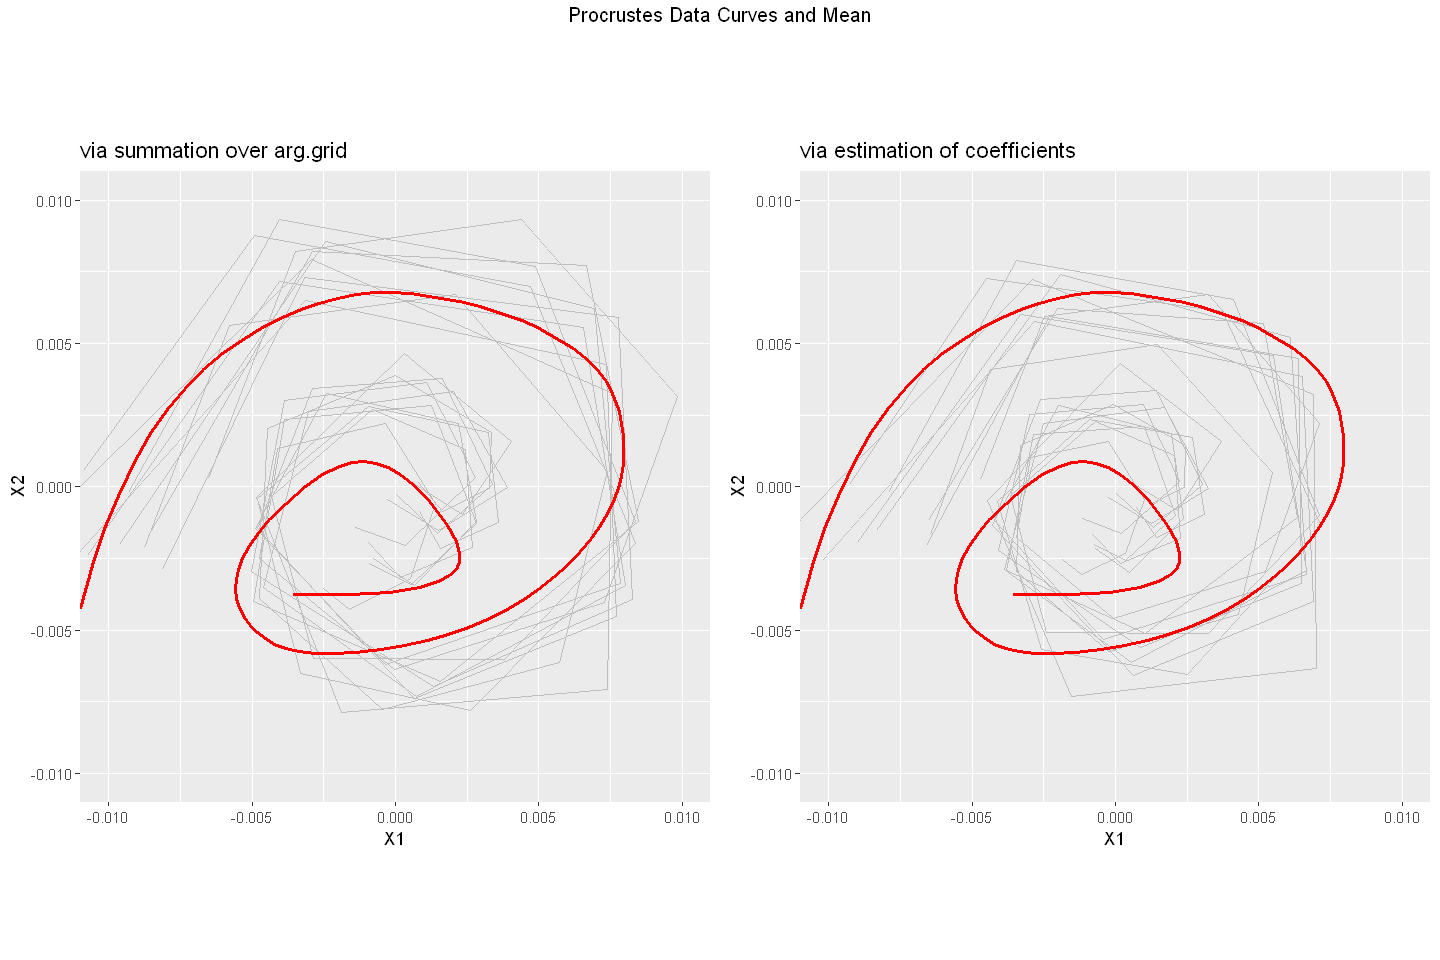

In [41]:
p1 <- ggplot(bind_rows(pfits, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=bt.xy, aes(x=X1, y=-X2), color = "red", size = 1) +
    coord_fixed(ylim=c(-0.01,0.01),xlim=c(-0.01,0.01)) +
    ggtitle("via summation over arg.grid")
   

p2 <- ggplot(bind_rows(pfits_coef, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=bt.xy, aes(x=X1, y=-X2), color = "red", size = 1) +
    coord_fixed(ylim=c(-0.01,0.01),xlim=c(-0.01,0.01)) +
    ggtitle("via estimation of coefficients")
    
options(repr.plot.width=12, repr.plot.height=8)
grid.arrange(p1, p2, nrow=1, top="Procrustes Data Curves and Mean")

In [42]:
# calculate procrustes fits of warped srv data curves, apply rot/scaling to uwarped curves
beta.mat.inv <- solve(beta.mat)

# Grab warped srv_data_curve from model_data.
q <- model_data_complex[model_data_complex$id == 4,]
# Create design matrix
q_B <- make_design(q$m_long, knots, closed = FALSE, type = type)
# smooth srv curve using calculated covariance
q_coefs <- solve(t(q_B) %*% q_B + beta.mat.inv) %*% t(Conj(q_B)) %*% q$q_m_long

ERROR: Error in make_design(q$m_long, knots, closed = FALSE, type = type): konnte Funktion "make_design" nicht finden


In [ ]:

test <- q_B %*% q_coefs
qtest <- data.frame(t = q$m_long, X1 = Re(test), X2 = Im(test))
btest <- get_points_from_srv(qtest)
btest <- center_curve(btest)
ggplot(btest) + geom_path(aes(x=X1, y=X2)) + coord_fixed()

In [ ]:
dim(t(q_B))